# Implementation of DLRM (Full/Faktor 2/FedPer) 

## Imports

In [2]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Layer, Input, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [3]:
# Load the dataset and fill the nan with 0
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns).fillna(0)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,0.0,893,0.0,0.0,4392.0,0.0,0.0,0.0,0.0,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.0,-1,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,0.0,2,0.0,2.0,41171.0,90.0,0.0,2.0,47.0,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,0.0,3,7.0,10.0,3912.0,400.0,2.0,17.0,104.0,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,0.0,1,48.0,0.0,17375.0,0.0,0.0,0.0,0.0,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,0.0,0,49.0,2.0,16610.0,0.0,0.0,6.0,0.0,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [4]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,07c540c4,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,e5ba7672,698d1c68,0,0,08119c8b,0,32c7478e,f96a556f,0,0
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,e5ba7672,7b06fafe,2f4b9dd2,a458ea53,033d948f,0,32c7478e,226b0ab6,2bf691b1,9aed84e6
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,1e88c74f,c21c3e4c,efa3470f,a458ea53,d3563291,0,bcdee96c,f88869fd,9b3e8820,86fe1bbe


In [5]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.126764,-0.267956,-0.039644,-0.661748,-0.250526,-0.228230,0.020912,-0.391033,0.389777,...,0,0,0,0,0,0,0,0,0,0
1,0,0.018618,-0.270689,0.104480,-0.536490,-0.269520,-0.217521,-0.208636,-0.391033,-0.454746,...,1,1,0,1,1,0,0,1,0,1
2,0,0.018618,-0.270689,-0.054426,1.091864,-0.259652,-0.000653,-0.173320,-0.391033,0.695141,...,2,2,1,2,2,1,0,2,1,2
3,0,-0.272146,2.170260,-0.058121,-0.661748,-0.205861,-0.238940,-0.243951,-0.460362,-0.473831,...,3,3,1,2,3,0,0,3,1,2
4,0,0.164000,-0.273423,-0.058121,-0.661748,-0.271004,-0.238940,-0.190978,-0.460362,-0.473831,...,3,4,1,2,4,0,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1364724,0,-0.272146,-0.265222,-0.058121,-0.411232,0.339901,0.002024,-0.243951,-0.391033,-0.249579,...,1,246,1,2,4,0,1,4,1,2
1364725,0,-0.272146,-0.262489,-0.032253,0.590832,-0.212983,0.832010,-0.208636,0.128934,0.022386,...,0,21,1,2,144,0,1,20,1,2
1364726,0,-0.272146,-0.267956,0.119262,-0.661748,-0.013207,-0.238940,-0.243951,-0.460362,-0.473831,...,0,88,96,3,315255,0,1,2096,11,5419
1364727,0,-0.272146,-0.270689,0.122957,-0.411232,-0.024558,-0.238940,-0.243951,-0.252375,-0.473831,...,3,49,73,3,315256,0,8,29121,3,22213


In [6]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.63203317288634%


In [7]:
# Select halfway point for the split
split_point = len(df) // 2

# Amplify integer features in the first half by multiplying by 2
df.loc[:split_point, 'I1':'I13'] *= 2

# Dampen those integer features in the second half by dividing by 2
df.loc[split_point:, 'I1':'I13'] /= 2

# Now split the DataFrame into two parts: one with amplified features and one with dampened features
df1 = df.iloc[:split_point].reset_index(drop=True)
df2 = df.iloc[split_point:].reset_index(drop=True)

# Verifying the manipulation
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)} - with amplified features")
print(f"df2 records: {len(df2)} - with dampened features")

Total records: 1364729
df1 records: 682364 - with amplified features
df2 records: 682365 - with dampened features


In [8]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [9]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [10]:
def MLP(arch, activation='relu', out_activation='sigmoid'):  # Ensure this matches your task
  mlp = tf.keras.Sequential()
  for units in arch[:-1]:
    mlp.add(tf.keras.layers.Dense(units, activation=activation))
  mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))
  return mlp

class BaseLayerModel(tf.keras.Model):
  def __init__(self, embedding_sizes, embedding_dim, arch_bot):
    super(BaseLayerModel, self).__init__()
    self.emb = [Embedding(size, embedding_dim, trainable=True) for size in embedding_sizes]
    self.bot_nn = MLP(arch_bot, out_activation='sigmoid')

  def call(self, inputs):
    input_dense, input_cat = inputs
    emb_x = [E(tf.expand_dims(x, axis=-1)) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
    dense_x = self.bot_nn(input_dense)
    return dense_x  # Correct for binary classification

# Instantiate and compile the base layer model
base_layer_model = BaseLayerModel(
  embedding_sizes=emb_counts,
  embedding_dim=2,
  arch_bot=[8, 2]
)

base_layer_model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy', AUC(name='auc')]
)

In [11]:
BATCH_SIZE = 128

history = base_layer_model.fit(
  ds_train.batch(BATCH_SIZE),
  validation_data=ds_valid.batch(BATCH_SIZE),
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
  epochs=5,
  verbose=1,
)

Epoch 1/5


4265/4265 [==============================] - 123s 27ms/step - loss: 0.6142 - accuracy: 0.7242 - auc: 0.7450 - val_loss: 0.5432 - val_accuracy: 0.7418 - val_auc: 0.8054
Epoch 2/5
4265/4265 [==============================] - 80s 19ms/step - loss: 0.5361 - accuracy: 0.7435 - auc: 0.8121 - val_loss: 0.5348 - val_accuracy: 0.7419 - val_auc: 0.8116
Epoch 3/5
4265/4265 [==============================] - 58s 14ms/step - loss: 0.5299 - accuracy: 0.7441 - auc: 0.8161 - val_loss: 0.5292 - val_accuracy: 0.7439 - val_auc: 0.8155
Epoch 4/5
4265/4265 [==============================] - 74s 17ms/step - loss: 0.5265 - accuracy: 0.7448 - auc: 0.8178 - val_loss: 0.5282 - val_accuracy: 0.7435 - val_auc: 0.8154
Epoch 5/5
4265/4265 [==============================] - 73s 17ms/step - loss: 0.5242 - accuracy: 0.7460 - auc: 0.8189 - val_loss: 0.5247 - val_accuracy: 0.7463 - val_auc: 0.8182


In [12]:
base_layer_model.summary()

Model: "base_layer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple             

In [13]:
results = base_layer_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 23s 12ms/step - loss: 0.5227 - accuracy: 0.7474 - auc: 0.8196
Loss: 0.5227383375167847, Accuracy: 0.7473598122596741, AUC: 0.8195825815200806


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.614239,0.724225,0.745022,0.543229,0.741811,0.805419
1,0.536092,0.743546,0.812127,0.534790,0.741921,0.811614
2,0.529851,0.744062,0.816082,0.529245,0.743863,0.815455
3,0.526480,0.744817,0.817808,0.528196,0.743497,0.815413
4,0.524212,0.746030,0.818939,0.524735,0.746318,0.818194


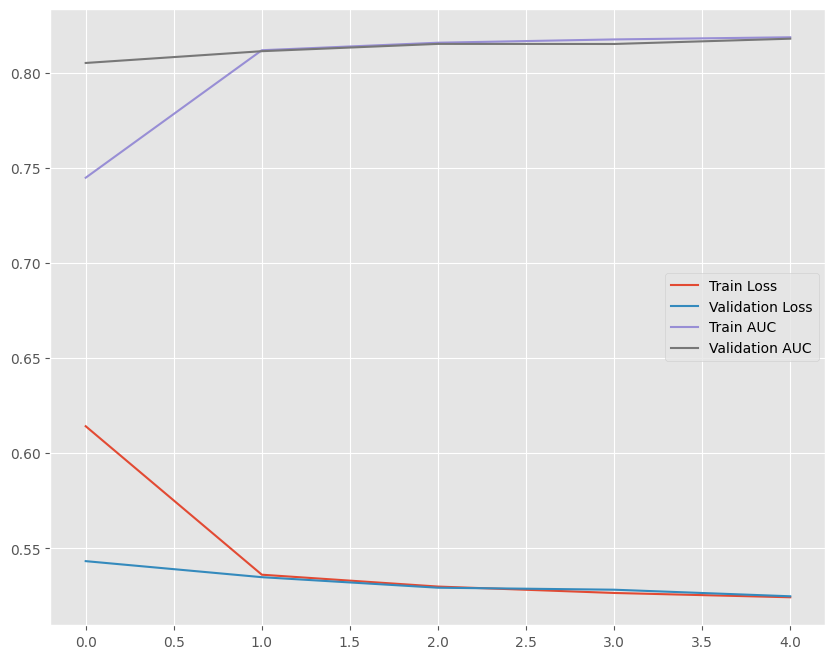

Validation AUC: 0.8190


In [14]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = base_layer_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = base_layer_model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [15]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in base_layer_model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [16]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:39608
Waiting for server to start

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


...................

Login to the Domain

In [17]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     Started server process [44121]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:39608 (Press CTRL+C to quit)



SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=57ff4a1bf1c64e2897f041fd0bc69246 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:52180 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:52180 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:52180 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:52180 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:52194 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [18]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> fb74619c5be9427bac5a15b113b373d0


In [19]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:52199 - "POST /api/v2/api_call HTTP/1.1" 200 OK
fb74619c5be9427bac5a15b113b373d0


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [20]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:52205 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52207 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [21]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/514b3d38c1f843a3a698b3cf4cbb5ed2.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=8300f23375f54a7bbf560d02df3d34c7 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_159: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:52223 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52229 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_159
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [22]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:52403 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52406 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:52409 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52411 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52414 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52416 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52420 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52424 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52426 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [23]:
request.approve()

INFO:     127.0.0.1:52406 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:52428 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52430 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52432 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52434 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52436 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52438 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52440 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:52442 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 68c004291f714617aa6d7102cff484c0 changes applied

In [24]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:52406 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [25]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/e9b039774da8456693a21fafb88a0de6.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=82312a61fd9f42a7a52ffd561875f083 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_5483: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:52470 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52473 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_5483
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [26]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [27]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [28]:
def MLP(arch, activation='relu', out_activation='sigmoid'):  # Ensure this matches your task
  mlp = tf.keras.Sequential()
  for units in arch[:-1]:
    mlp.add(tf.keras.layers.Dense(units, activation=activation))
  mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))
  return mlp

class BaseLayerModel(tf.keras.Model):
  def __init__(self, embedding_sizes, embedding_dim, arch_bot):
    super(BaseLayerModel, self).__init__()
    self.emb = [Embedding(size, embedding_dim, trainable=True) for size in embedding_sizes]
    self.bot_nn = MLP(arch_bot, out_activation='sigmoid')

  def call(self, inputs):
    input_dense, input_cat = inputs
    emb_x = [E(tf.expand_dims(x, axis=-1)) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
    dense_x = self.bot_nn(input_dense)
    return dense_x  # Correct for binary classification

# Instantiate and compile the base layer model
base_layer_model = BaseLayerModel(
  embedding_sizes=emb_counts,
  embedding_dim=2,
  arch_bot=[8, 2]
)

base_layer_model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy', AUC(name='auc')]
)

In [29]:
BATCH_SIZE = 128

history = base_layer_model.fit(
  ds_train.batch(BATCH_SIZE),
  validation_data=ds_valid.batch(BATCH_SIZE),
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
  epochs=5,
  verbose=1,
)

Epoch 1/5


4265/4265 [==============================] - 54s 12ms/step - loss: 0.5648 - accuracy: 0.7325 - auc: 0.7843 - val_loss: 0.5221 - val_accuracy: 0.7543 - val_auc: 0.8213
Epoch 2/5
4265/4265 [==============================] - 28s 7ms/step - loss: 0.5215 - accuracy: 0.7525 - auc: 0.8214 - val_loss: 0.5158 - val_accuracy: 0.7561 - val_auc: 0.8255
Epoch 3/5
4265/4265 [==============================] - 39s 9ms/step - loss: 0.5187 - accuracy: 0.7538 - auc: 0.8233 - val_loss: 0.5153 - val_accuracy: 0.7554 - val_auc: 0.8258
Epoch 4/5
4265/4265 [==============================] - 34s 8ms/step - loss: 0.5178 - accuracy: 0.7545 - auc: 0.8240 - val_loss: 0.5145 - val_accuracy: 0.7565 - val_auc: 0.8266
Epoch 5/5
4265/4265 [==============================] - 26s 6ms/step - loss: 0.5172 - accuracy: 0.7548 - auc: 0.8244 - val_loss: 0.5143 - val_accuracy: 0.7569 - val_auc: 0.8264


In [30]:
base_layer_model.summary()

Model: "base_layer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2632      
                                                                 
 embedding_1 (Embedding)     multiple                  1066      
                                                                 
 embedding_2 (Embedding)     multiple                  849010    
                                                                 
 embedding_3 (Embedding)     multiple                  303040    
                                                                 
 embedding_4 (Embedding)     multiple                  558       
                                                                 
 embedding_5 (Embedding)     multiple                  32        
                                                                 
 embedding_6 (Embedding)     multiple             

In [31]:
results = base_layer_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 10s 6ms/step - loss: 0.5150 - accuracy: 0.7563 - auc: 0.8258
Loss: 0.5150228142738342, Accuracy: 0.7563267946243286, AUC: 0.8258037567138672


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.564843,0.732464,0.784301,0.522060,0.754305,0.821262
1,0.521511,0.752466,0.821423,0.515842,0.756064,0.825478
2,0.518668,0.753753,0.823343,0.515266,0.755404,0.825842
3,0.517787,0.754468,0.823962,0.514537,0.756540,0.826566
4,0.517205,0.754843,0.824357,0.514325,0.756906,0.826418


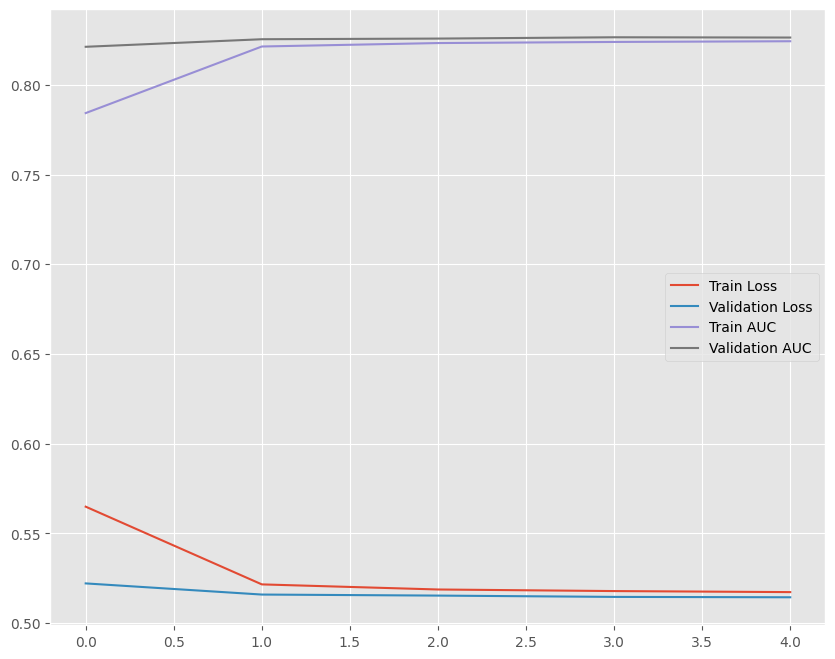

Validation AUC: 0.8258


In [32]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = base_layer_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = base_layer_model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [33]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in base_layer_model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [34]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:25160
Waiting for server to start

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


..............

INFO:     Started server process [44281]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:25160 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=590ef0f31db74ab0bf07d90c15ec0f86 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:52823 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [35]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:52825 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:52825 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:52825 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:52825 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:52833 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [36]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 6639594e2248448ba0203c6f801ff0c5


In [37]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:52837 - "POST /api/v2/api_call HTTP/1.1" 200 OK
6639594e2248448ba0203c6f801ff0c5


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [38]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:52843 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52845 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52847 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [39]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/c68a4f4002bd475dad0c4a5e06582813.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=0b5de151e97c46b58be9c72905cf602e in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_3924: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:52857 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52859 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_3924
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [40]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:52939 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52942 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:52946 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52948 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52950 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52952 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52954 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52956 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52958 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [41]:
request.approve()

INFO:     127.0.0.1:52942 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:52960 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52962 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52964 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52966 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52968 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52970 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:52972 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:52974 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request 3f0291414dc341fcb1e7e5cde9b740d8 changes applied

In [42]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:52942 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [43]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/5a886b7caccd4459bfa98e7ab9cc3400.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=4fea6e19c38c4f6ea63ab04638af1c71 in_memory=True
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Timeout elapsed after 30 seconds while trying to acquiring lock.
FAILED TO LOCK
Failed to create container: Worker: syft.service.worker.worker_pool.SyftWorker,Error: Failed to acquire lock for the operation
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_9116: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:53023 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53025 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_9116
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [44]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [45]:
weights1 = weights_local
weights2 = weights_local_2

In [46]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [47]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Global Model Base and Local Top Layer 

In [48]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [49]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

# Global Model Layer
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()
    for units in arch[:-1]:
        mlp.add(Dense(units, activation=activation))
    mlp.add(Dense(arch[-1], activation=out_activation))
    return mlp

class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interacation=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)
        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)
        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2) if self.self_interaction else int(len(inputs) * (len(inputs) - 1) / 2)
        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions

class BaseDLRM(Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot):
        super(BaseDLRM, self).__init__()
        self.emb = [Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)
        return dense_x, emb_x

    def update_global_weights(self, global_weights):
        #Updates the model's weights with the provided global weights.
        self.set_weights(global_weights)

class PersonalizationModel(Model):
    def __init__(self, arch_top):
        super(PersonalizationModel, self).__init__()
        self.top_nn = MLP(arch_top, out_activation='sigmoid')

    def call(self, inputs):
        dense_x, emb_x = inputs
        z = concatenate([dense_x] + emb_x, axis=1)
        p = self.top_nn(z)
        return p

class FederatedPersonalizedModel(Model):
    def __init__(self, base_model, arch_top):
        super(FederatedPersonalizedModel, self).__init__()
        self.base_model = base_model
        self.personalization_model = PersonalizationModel(arch_top)

    def call(self, inputs):
        base_output = self.base_model(inputs)
        final_output = self.personalization_model(base_output)
        return final_output


In [50]:
base_model = BaseDLRM(embedding_sizes, embedding_dim, arch_bot)
personalized_model = FederatedPersonalizedModel(base_model, arch_top)



# Assuming 'base_model' and 'personalized_model' are correctly defined as before
personalized_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]  # Correctly pass metrics as a list
)


In [51]:
BATCH_SIZE = 128

history = personalized_model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 375s 81ms/step - loss: 0.4819 - accuracy: 0.7736 - auc: 0.8498 - val_loss: 0.4712 - val_accuracy: 0.7794 - val_auc: 0.8572
Epoch 2/5
4265/4265 [==============================] - 313s 73ms/step - loss: 0.3755 - accuracy: 0.8354 - auc: 0.9125 - val_loss: 0.5335 - val_accuracy: 0.7484 - val_auc: 0.8190
Epoch 3/5
4265/4265 [==============================] - 353s 83ms/step - loss: 0.3067 - accuracy: 0.8644 - auc: 0.9420 - val_loss: 0.6087 - val_accuracy: 0.7533 - val_auc: 0.8144
Epoch 4/5
4265/4265 [==============================] - 264s 62ms/step - loss: 0.2738 - accuracy: 0.8768 - auc: 0.9535 - val_loss: 0.6410 - val_accuracy: 0.7482 - val_auc: 0.8079
Epoch 5/5
4265/4265 [==============================] - 218s 51ms/step - loss: 0.2522 - accuracy: 0.8859 - auc: 0.9604 - val_loss: 0.6459 - val_accuracy: 0.7446 - val_auc: 0.8060


In [52]:
personalized_model.summary()

Model: "federated_personalized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_dlrm (BaseDLRM)        multiple                  3336956   
                                                                 
 personalization_model (Per  multiple                  15426     
 sonalizationModel)                                              
                                                                 
Total params: 3352382 (12.79 MB)
Trainable params: 3352382 (12.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
results = personalized_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 12s 7ms/step - loss: 0.6709 - accuracy: 0.7365 - auc: 0.7948
Loss: 0.6708595156669617, Accuracy: 0.7364603281021118, AUC: 0.7947756052017212


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.481895,0.773649,0.849759,0.471200,0.779439,0.857182
1,0.375533,0.835434,0.912479,0.533474,0.748370,0.819025
2,0.306694,0.864449,0.941963,0.608704,0.753279,0.814381
3,0.273776,0.876789,0.953489,0.640998,0.748186,0.807942
4,0.252171,0.885869,0.960407,0.645902,0.744633,0.806020


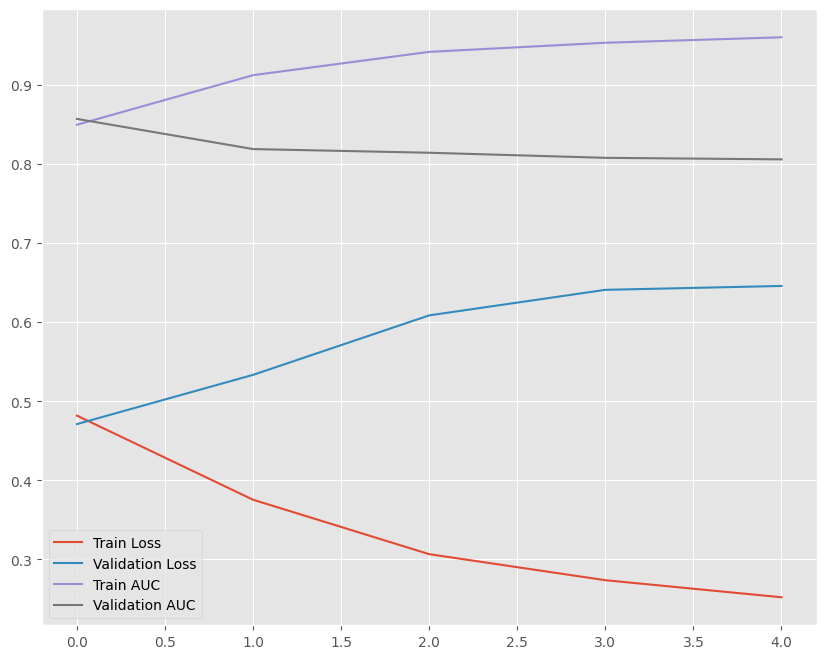

In [54]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [55]:
# Evaluate the model on the validation dataset
val_metrics = personalized_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = personalized_model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8047


In [56]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 95.52%


# Data Owner 2 with Global Model Base and Local Top Layer 

In [57]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [58]:
# Global Model Layer

embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()
    for units in arch[:-1]:
        mlp.add(Dense(units, activation=activation))
    mlp.add(Dense(arch[-1], activation=out_activation))
    return mlp

class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interacation=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)
        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)
        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2) if self.self_interaction else int(len(inputs) * (len(inputs) - 1) / 2)
        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions

class BaseDLRM(Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot):
        super(BaseDLRM, self).__init__()
        self.emb = [Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)
        return dense_x, emb_x

    def update_global_weights(self, global_weights):
        #Updates the model's weights with the provided global weights.
        self.set_weights(global_weights)

class PersonalizationModel(Model):
    def __init__(self, arch_top):
        super(PersonalizationModel, self).__init__()
        self.top_nn = MLP(arch_top, out_activation='sigmoid')

    def call(self, inputs):
        dense_x, emb_x = inputs
        z = concatenate([dense_x] + emb_x, axis=1)
        p = self.top_nn(z)
        return p

class FederatedPersonalizedModel(Model):
    def __init__(self, base_model, arch_top):
        super(FederatedPersonalizedModel, self).__init__()
        self.base_model = base_model
        self.personalization_model = PersonalizationModel(arch_top)

    def call(self, inputs):
        base_output = self.base_model(inputs)
        final_output = self.personalization_model(base_output)
        return final_output


In [59]:
base_model = BaseDLRM(embedding_sizes, embedding_dim, arch_bot)
personalized_model = FederatedPersonalizedModel(base_model, arch_top)



# Assuming 'base_model' and 'personalized_model' are correctly defined as before
personalized_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]  # Correctly pass metrics as a list
)


In [60]:
BATCH_SIZE = 128

history =personalized_model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
4265/4265 [==============================] - 147s 33ms/step - loss: 0.4775 - accuracy: 0.7781 - auc: 0.8530 - val_loss: 0.4642 - val_accuracy: 0.7849 - val_auc: 0.8618
Epoch 2/5
4265/4265 [==============================] - 140s 33ms/step - loss: 0.3745 - accuracy: 0.8363 - auc: 0.9130 - val_loss: 0.5300 - val_accuracy: 0.7612 - val_auc: 0.8300
Epoch 3/5
4265/4265 [==============================] - 184s 43ms/step - loss: 0.3045 - accuracy: 0.8655 - auc: 0.9427 - val_loss: 0.6092 - val_accuracy: 0.7538 - val_auc: 0.8134
Epoch 4/5
4265/4265 [==============================] - 105s 25ms/step - loss: 0.2732 - accuracy: 0.8774 - auc: 0.9536 - val_loss: 0.6755 - val_accuracy: 0.7426 - val_auc: 0.8000
Epoch 5/5
4265/4265 [==============================] - 75s 18ms/step - loss: 0.2534 - accuracy: 0.8862 - auc: 0.9600 - val_loss: 0.6479 - val_accuracy: 0.7380 - val_auc: 0.7999


In [61]:
personalized_model.summary()

Model: "federated_personalized_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_dlrm (BaseDLRM)        multiple                  3336956   
                                                                 
 personalization_model (Per  multiple                  15426     
 sonalizationModel)                                              
                                                                 
Total params: 3352382 (12.79 MB)
Trainable params: 3352382 (12.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
results = personalized_model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

853/853 [==============================] - 8s 5ms/step - loss: 0.6634 - accuracy: 0.7328 - auc: 0.7924
Loss: 0.6633650064468384, Accuracy: 0.7328423857688904, AUC: 0.7923857569694519


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.477530,0.778084,0.852957,0.464194,0.784861,0.861807
1,0.374492,0.836341,0.912971,0.529966,0.761156,0.830033
2,0.304519,0.865497,0.942714,0.609173,0.753792,0.813351
3,0.273231,0.877384,0.953588,0.675457,0.742617,0.799976
4,0.253404,0.886216,0.959963,0.647950,0.738038,0.799937


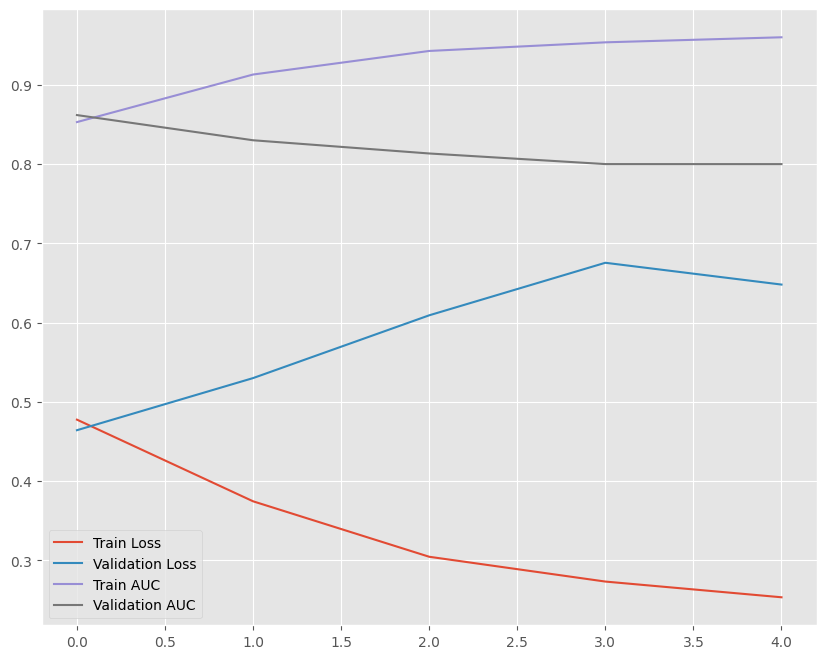

In [63]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [64]:
# Evaluate the model on the validation dataset
val_metrics = personalized_model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = personalized_model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8002


In [65]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 92.17%
